# Naive vs IPS

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import torch
from torch.optim import Adam
from pytorchltr.datasets import MSLR10K

from model import MLPScoreFunc, LinearRegression
from train import train_ranker

import warnings
warnings.filterwarnings('ignore')

/root/.cache/pypoetry/virtualenvs/mldesign-9TtSrW0h-py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# 実験設定
batch_size = 8
hidden_layer_sizes = (3, 2)
learning_rate = 0.001
n_epochs = 10

In [24]:
#train_10K = MSLR10K(split="train")
#test_10K = MSLR10K(split="test")

In [3]:
import joblib

#with open("../data/MSLR10K.pkl", "wb") as f:
#    joblib.dump([train_10K, test_10K], f)
with open("../data/MSLR10K.pkl", "rb") as f:
    train, test = joblib.load(f)

In [4]:
len(test)

1928

# Naive推定量に基づいた学習

In [12]:
torch.manual_seed(12345)
score_fn = MLPScoreFunc(
    input_size=train[0].features.shape[1],
    hidden_layer_sizes=hidden_layer_sizes
)

optimizer = Adam(score_fn.parameters(), lr=learning_rate)

ndcg_score_list_naive = train_ranker(
    score_fn=score_fn,
    optimizer=optimizer,
    estimator="naive",
    train=train,
    test=test,
    batch_size=batch_size,
    pow_true=1.0,
    n_epochs=n_epochs,
)

100% 10/10 [05:49<00:00, 34.93s/it]


# IPS推定量に基づいた学習

In [13]:
torch.manual_seed(12345)
score_fn = MLPScoreFunc(
    input_size=train[0].features.shape[1],
    hidden_layer_sizes=hidden_layer_sizes
)

optimizer = Adam(score_fn.parameters(), lr=learning_rate)

ndcg_score_list_ips = train_ranker(
    score_fn=score_fn,
    optimizer=optimizer,
    estimator="ips",
    train=train,
    test=test,
    batch_size=batch_size,
    pow_true=1.0,
    n_epochs=n_epochs
)

100% 10/10 [05:56<00:00, 35.61s/it]


# 真の嗜好度合いに基づいた学習(explicit feedback)

In [14]:
torch.manual_seed(12345)
score_fn = MLPScoreFunc(
    input_size=train[0].features.shape[1],
    hidden_layer_sizes=hidden_layer_sizes
)

optimizer = Adam(score_fn.parameters(), lr=learning_rate)

ndcg_score_list_ideal = train_ranker(
    score_fn=score_fn,
    optimizer=optimizer,
    estimator="ideal",
    train=train,
    test=test,
    batch_size=batch_size,
    pow_true=1.0,
    n_epochs=n_epochs,
)

100% 10/10 [05:53<00:00, 35.33s/it]


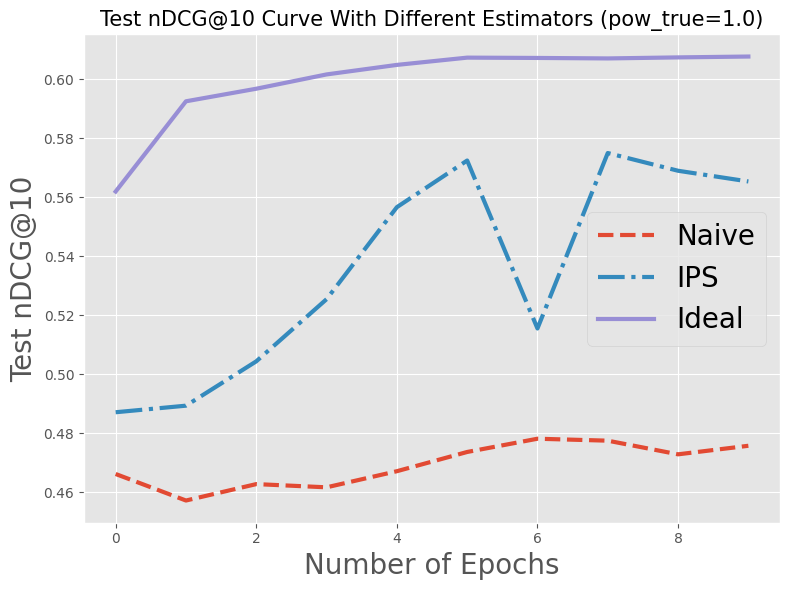

In [15]:
plt.subplots(1, figsize=(8,6))
plt.plot(range(n_epochs), ndcg_score_list_naive, label="Naive", linewidth=3, linestyle="dashed")
plt.plot(range(n_epochs), ndcg_score_list_ips, label="IPS", linewidth=3, linestyle="dashdot")
plt.plot(range(n_epochs), ndcg_score_list_ideal, label="Ideal", linewidth=3)

plt.title("Test nDCG@10 Curve With Different Estimators (pow_true=1.0)", fontdict=dict(size=15))
plt.xlabel("Number of Epochs", fontdict=dict(size=20))
plt.ylabel("Test nDCG@10", fontdict=dict(size=20))
plt.tight_layout()
plt.legend(loc="best", fontsize=20)
plt.show()
